Imports

In [57]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

Configurations

In [58]:
TRAIN_IMG_FOLDER_PATH = 'Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = 'Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

#DEVICE = 'cuda' or 'cpu'
DEVICE = 'mps'
MODEL_NAME = 'efficientnet_b0'



Load Dataset

In [59]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T 

In [60]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor()
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [61]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_augs)

In [62]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [63]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '4')

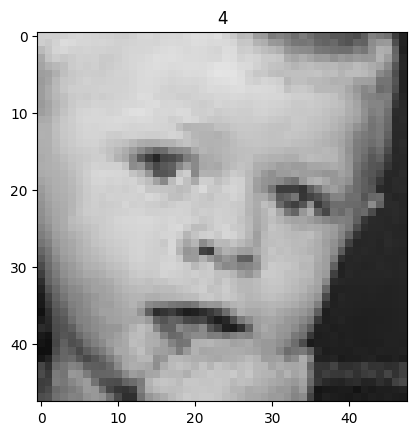

In [64]:
image, label = validset[4000]
plt.imshow(image.permute(1,2,0)) #normalize tensor image to (h,w,c)
plt.title(label)

Load Dataset into Batches

In [65]:
from torch.utils.data import DataLoader

In [66]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [67]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [68]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


Create Model

In [69]:
import timm 
from torch import nn 

In [70]:
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()
        self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)
        
    def forward(self, images, labels = None):
        logits = self.eff_net(images)
        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss
        return logits

In [71]:
model = FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

Create Train and Eval Function

In [72]:
from tqdm import tqdm

In [73]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [74]:
def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "(TRAIN)" + str(current_epoch + 1) + "/" + str(EPOCHS))

    for t,data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss':'%6f %float(total_loss/(t+1))', 'acc':'%6f %float(total_acc/(t+1))'})
        
    return total_loss/len(dataloader),total_acc/len(dataloader)

In [75]:
def eval_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "(TRAIN)" + str(current_epoch + 1) + "/" + str(EPOCHS))

    for t,data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits, loss = model(images, labels)

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss':'%6f %float(total_loss/(t+1))', 'acc':'%6f %float(total_acc/(t+1))'})
        
    return total_loss/len(dataloader),total_acc/len(dataloader)

Create Training Loop

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [78]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
    train_loass, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, vsalid_acc = eval_fn(model, validloader, i)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss

EPOCH(TRAIN)1/15: 100%|██████████████| 221/221 [00:07<00:00, 30.81it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)3/15: 100%|██████████████| 221/221 [00:06<00:00, 33.81it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)4/15: 100%|██████████████| 221/221 [00:06<00:00, 33.65it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)5/15: 100%|██████████████| 221/221 [00:06<00:00, 31.76it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)7/15: 100%|██████████████| 221/221 [00:06<00:00, 34.31it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)9/15: 100%|██████████████| 221/221 [00:06<00:00, 34.09it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)10/15: 100%|█████████████| 221/221 [00:06<00:00, 33.26it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)11/15: 100%|█████████████| 221/221 [00:06<00:00, 33.78it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


SAVED-BEST-WEIGHTS


EPOCH(TRAIN)15/15: 100%|█████████████| 221/221 [00:06<00:00, 33.37it/s, loss=%6f %float(total_loss/(t+1)), acc=%6f %float(total_acc/(t+1))]


Inference

In [79]:
def view_classify(img, ps):
    
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.mps().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
   
    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None